<a href="https://colab.research.google.com/github/Ichraf-MOUELHI/Fraud_detection/blob/main/IM_Detection_fraud_euros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
import seaborn as sns


# **Importation des données**

In [38]:
# URL vers les fichiers CSV hébergés sur GitHub
url_billets = 'https://raw.githubusercontent.com/Ichraf-MOUELHI/Fraud_detection/refs/heads/main/billets.csv'
url_billets_prod = 'https://raw.githubusercontent.com/Ichraf-MOUELHI/Fraud_detection/refs/heads/main/billets_test.csv'
url_billets_genere = 'https://raw.githubusercontent.com/Ichraf-MOUELHI/Fraud_detection/refs/heads/main/billets_data1.csv'


# Chargement des fichiers directement depuis GitHub
billets = pd.read_csv(url_billets)
billets_prod = pd.read_csv(url_billets_prod)
billets_genere = pd.read_csv(url_billets_genere)


# **Recherche sur le choix du modèle**

# **Exploration et Nettoyage des données**

In [39]:
billets.head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,"171,81","104,86","104,95","4,52","2,89","112,83"
1,True,"171,46","103,36","103,66","3,77","2,99","113,09"
2,True,"172,69","104,48","103,50","4,40","2,94","113,16"
3,True,"171,36","103,91","103,94","3,62","3,01","113,51"
4,True,"171,73","104,28","103,46","4,04","3,48","112,54"


In [40]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_genuine    1500 non-null   bool  
 1   diagonal      1500 non-null   object
 2   height_left   1500 non-null   object
 3   height_right  1500 non-null   object
 4   margin_low    1463 non-null   object
 5   margin_up     1500 non-null   object
 6   length        1500 non-null   object
dtypes: bool(1), object(6)
memory usage: 71.9+ KB


In [41]:
# Modifier le type de données des colonnes
# Vérifier si la colonne est déjà numérique avant d'appliquer str.replace
if billets['diagonal'].dtype == object:  # Si la colonne est de type object, elle contient probablement des chaînes
    billets['diagonal'] = billets['diagonal'].str.replace(',', '.').astype(float)
else:
    print("La colonne 'diagonal' est déjà numérique. str.replace ignoré.")

# Appliquer la même logique aux autres colonnes
if billets['height_left'].dtype == object:
    billets['height_left'] = billets['height_left'].str.replace(',', '.').astype(float)
else:
    print("La colonne 'height_left' est déjà numérique. str.replace ignoré.")

if billets['height_right'].dtype == object:
    billets['height_right'] = billets['height_right'].str.replace(',', '.').astype(float)
else:
    print("La colonne 'height_right' est déjà numérique. str.replace ignoré.")

if billets['margin_low'].dtype == object:
    billets['margin_low'] = billets['margin_low'].str.replace(',', '.').astype(float)
else:
    print("La colonne 'margin_low' est déjà numérique. str.replace ignoré.")

if billets['margin_up'].dtype == object:
    billets['margin_up'] = billets['margin_up'].str.replace(',', '.').astype(float)
else:
    print("La colonne 'margin_up' est déjà numérique. str.replace ignoré.")

if billets['length'].dtype == object:
    billets['length'] = billets['length'].str.replace(',', '.').astype(float)
else:
    print("La colonne 'length' est déjà numérique. str.replace ignoré.")

In [42]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [43]:
billets.isna().sum()

,0
is_genuine,0
diagonal,0
height_left,0
height_right,0
margin_low,37
margin_up,0
length,0


In [44]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


# **Regression linéaire pour determiner les valeurs manquantes de margin_low**

In [45]:
from sklearn.linear_model import LinearRegression

# Vérifier s'il y a des valeurs manquantes dans 'margin_low' avant de continuer
if billets['margin_low'].isnull().any():
    # Identifier les lignes avec et sans valeurs manquantes pour margin_low
    donnees_entrainement = billets[billets['margin_low'].notnull()]  # Données sans valeurs manquantes
    donnees_manquantes = billets[billets['margin_low'].isnull()]  # Données avec valeurs manquantes

    # Variables indépendantes (caractéristiques) et dépendante (cible)
    caracteristiques = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']
    X_entrainement = donnees_entrainement[caracteristiques]
    y_entrainement = donnees_entrainement['margin_low']
    X_manquantes = donnees_manquantes[caracteristiques]

    # Entraîner le modèle de régression linéaire
    modele_regression = LinearRegression()
    modele_regression.fit(X_entrainement, y_entrainement)

    # Prédire les valeurs manquantes
    valeurs_predites = modele_regression.predict(X_manquantes)

    # Remplir les valeurs manquantes dans le DataFrame original
    billets.loc[billets['margin_low'].isnull(), 'margin_low'] = valeurs_predites

    # Vérifier s'il reste des valeurs manquantes
    print(f"Nombre de valeurs manquantes restantes dans 'margin_low': {billets['margin_low'].isnull().sum()}")
else:
    print("Aucune valeur manquante trouvée dans 'margin_low'. Le modèle de régression linéaire n'est pas nécessaire.")

Nombre de valeurs manquantes restantes dans 'margin_low': 0


In [46]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.483475,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659632,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


# **Distribution**

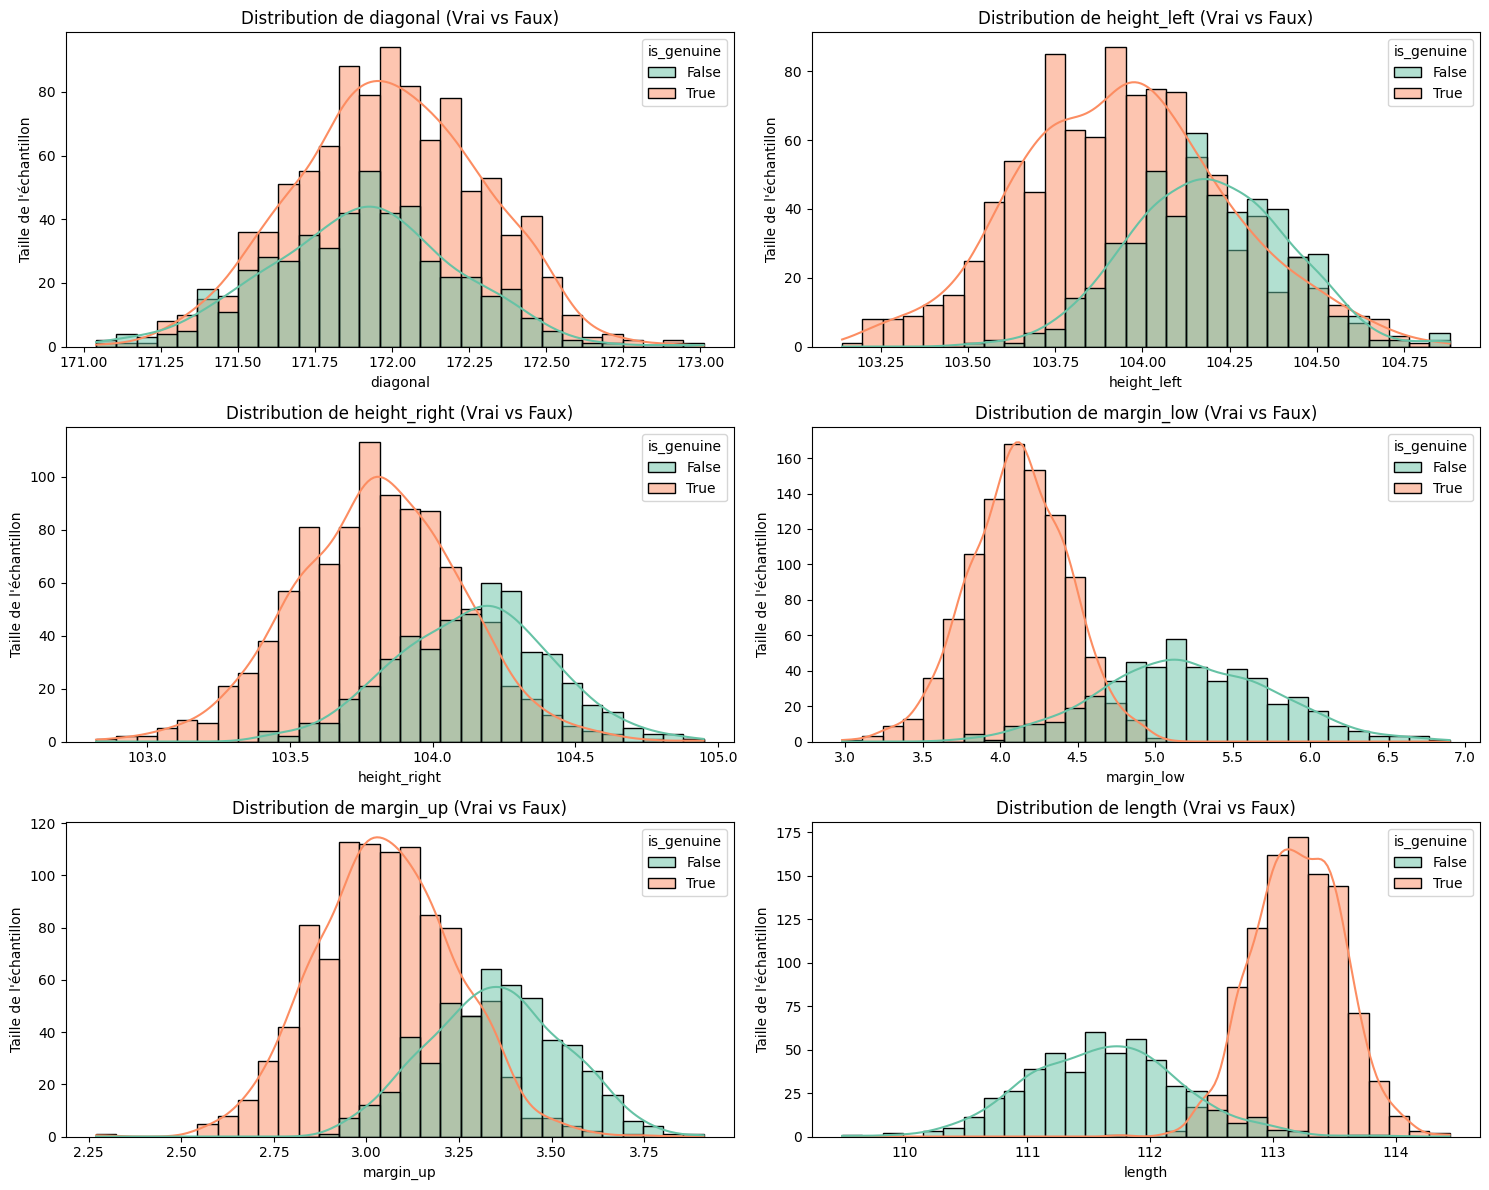

In [47]:
# Colonnes à visualiser
features = billets.columns[1:]  # Toutes les colonnes sauf is_genuine

# Taille de la figure
plt.figure(figsize=(15, 12))

# Boucle pour tracer chaque feature
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)  # Organiser les graphiques en 3 lignes, 2 colonnes
    sns.histplot(billets, x=feature, hue="is_genuine", kde=True, bins=30, palette="Set2")
    plt.title(f'Distribution de {feature} (Vrai vs Faux)')
    plt.xlabel(feature)
    plt.ylabel('Taille de l\'échantillon')

plt.tight_layout()
plt.show()



# **Observations :**

**1. Diagonal**

Les vrais billets (True) ont une diagonale plus longue et sont concentrés autour de "172" légèrement supérieure à celle des faux billets.
Les faux billets (False) montrent une distribution légèrement plus étalée vers les valeurs plus petites.
Séparabilité : Une différence notable entre les deux classes est observable, mais il y a un chevauchement.

**2. Height_left**

La hauteur gauche (height_left) est centrée autour d'une valeur de "104" moins élevée pour les vrais billets que pour les faux.
Les distributions se chevauchent, mais les vrais billets ont une concentration légèrement plus forte vers des valeurs élevées.
Séparabilité : La différenciation est modérée.

**3. Height_right**

La hauteur droite (height_right) suit une tendance similaire à celle de height_left.
Les vrais billets ont une distribution centrée plus haut, mais avec un chevauchement notable.
Séparabilité : Faible à modérée, similaire à height_left.

**4. Margin_low**
Les vrais billets ont une marge basse (margin_low) concentrée autour de (4,1), tandis que les faux billets tendent vers des valeurs plus grandes (autour de 5.2).
Le chevauchement est limité, ce qui suggère une bonne capacité de séparation.
Séparabilité : Forte.

**5. Margin_up**

Les vrais billets montrent des marges supérieures (margin_up) concentrées autour de valeurs moins élevées (3,1) alors que les faux billets se concentrent sur des valeurs plus élevées (3,3).
Comme pour margin_low, les distributions sont assez distinctes.
Séparabilité : Forte.

**6. Length**

Les faux billets ont une longueur (length) centrée sur des valeurs plus basses avec une distribution plus étalée.
Les faux billets tendent vers des longueurs plus élevées et présentent une distribution plus serrée.
Séparabilité : Modérée à forte.


**Les variables margin_low, margin_up et length semblent offrir une bonne séparation entre vrais et faux billets.
Les variables diagonal, height_left, et height_right contribuent également, mais présentent un chevauchement plus important.
Ces observations peuvent être utilisées pour identifier les caractéristiques les plus importantes dans un modèle de classification.**


# **Test de normalité statistique**
# **Test de Shapiro-Wilk**

Vérifie si une variable suit une distribution normale.

**H0:** les données suivent une distribution normale.

**Si la p-value est inférieure à 0.05, on rejette H0 (les données ne suivent pas une distribution normale).**

In [48]:
from scipy.stats import shapiro

for feature in features:
    stat, p_value = shapiro(billets[feature])
    print(f"{feature}: W-stat={stat:.4f}, p-value={p_value:.4f}")


diagonal: W-stat=0.9987, p-value=0.3241
height_left: W-stat=0.9979, p-value=0.0514
height_right: W-stat=0.9995, p-value=0.9800
margin_low: W-stat=0.9375, p-value=0.0000
margin_up: W-stat=0.9962, p-value=0.0008
length: W-stat=0.9176, p-value=0.0000


**- Diagonal:**  p-value=0.3241 > 0.05 la variable suit une distribution normale

**-height_left:** p-value=0.0514 > 0.05 la variable suit une distribution normale

**-height_right:**  p-value=0.9800 > 0.05 la variable suit une distribution normale

**-margin_low:** p-value=0.0000 < 0.05 la variable ne suit pas une distribution normale.

**-margin_up:**  p-value=0.0008 < 0.05 la variable ne suit pas une distribution normale.

**-length:** p-value=0.0000 < 0.05 la variable ne suit pas une distribution normale.

# **Création et ajustement d'un modèle linéaire**

In [49]:
import statsmodels.api as sm
import numpy as np

# Séparer les variables explicatives (features) et la cible (is_genuine)
X = billets[features]
y = billets['is_genuine']

# Ajouter une constante pour le modèle linéaire
X = sm.add_constant(X)

# Ajuster le modèle linéaire
model = sm.OLS(y, X).fit()

# Obtenir les prédictions et les résidus
predictions = model.predict(X)
residuals = y - predictions

# Résumé du modèle
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             is_genuine   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     1316.
Date:                Wed, 02 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:05:47   Log-Likelihood:                 378.63
No. Observations:                1500   AIC:                            -743.3
Df Residuals:                    1493   BIC:                            -706.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -12.4710      3.749     -3.326   

# **Test de normalité des résidus**

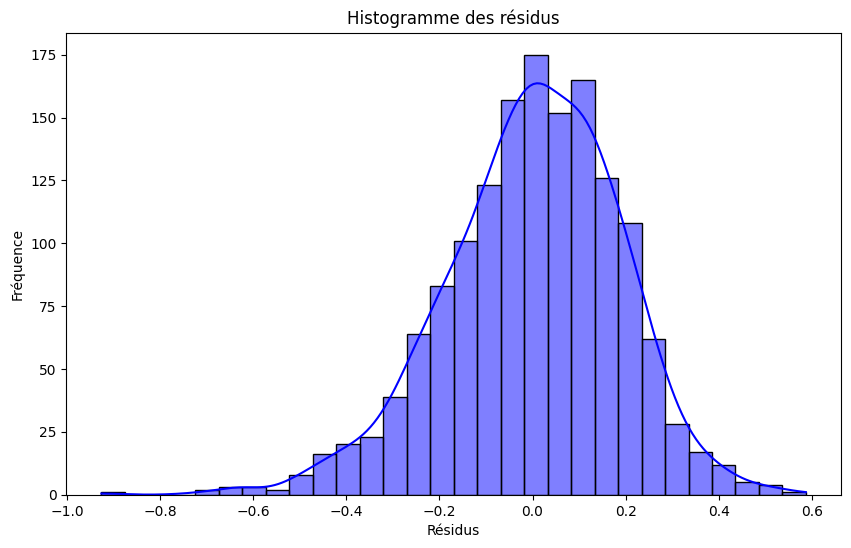

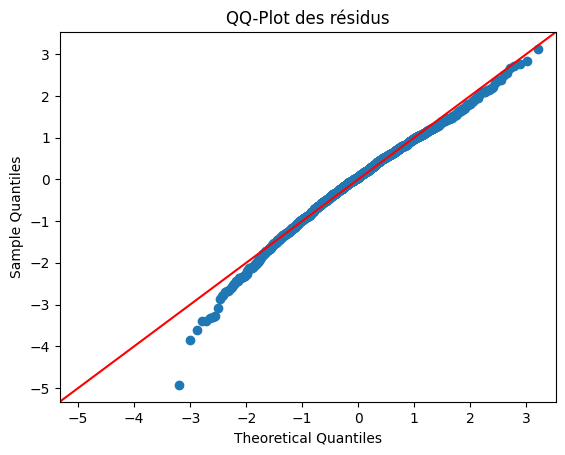

Shapiro-Wilk Test: Statistique = 0.989, p-value = 0.000
Les résidus ne suivent pas une distribution normale.


In [50]:
# Import des bibliothèques nécessaires
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# Histogramme des résidus
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color="blue")
plt.title("Histogramme des résidus")
plt.xlabel("Résidus")
plt.ylabel("Fréquence")
plt.show()

# QQ-Plot
sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ-Plot des résidus")
plt.show()

# Test de Shapiro-Wilk
stat, p_value = shapiro(residuals)
print(f"Shapiro-Wilk Test: Statistique = {stat:.3f}, p-value = {p_value:.3f}")
if p_value < 0.05:
    print("Les résidus ne suivent pas une distribution normale.")
else:
    print("Les résidus suivent une distribution normale.")


# **Test d’homoscédasticité**

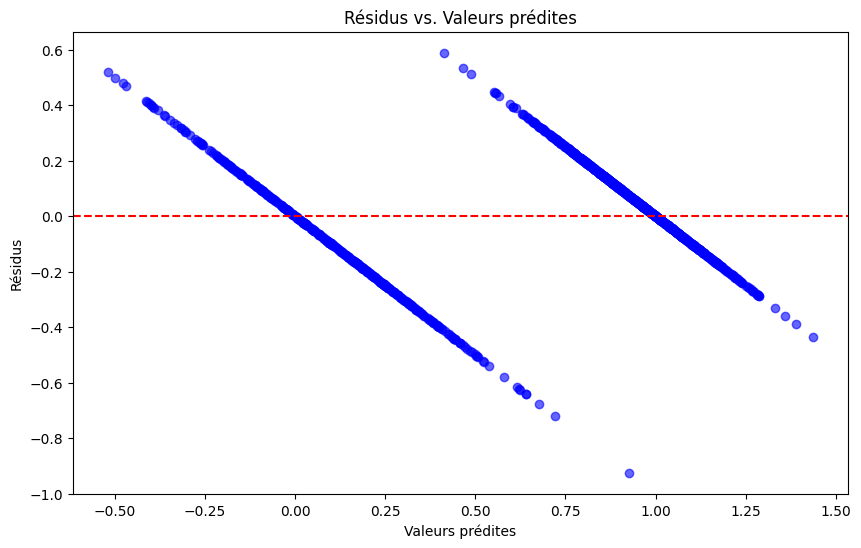

Breusch-Pagan Test: Statistique = 91.217, p-value = 0.000
Hétéroscédasticité détectée (homoscédasticité rejetée).


In [51]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Résidus vs. valeurs prédites
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.6, color="blue")
plt.axhline(0, color='red', linestyle='--')
plt.title("Résidus vs. Valeurs prédites")
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.show()

# Test de Breusch-Pagan
bp_test = het_breuschpagan(residuals, X)
stat, p_value = bp_test[0], bp_test[1]
print(f"Breusch-Pagan Test: Statistique = {stat:.3f}, p-value = {p_value:.3f}")
if p_value < 0.05:
    print("Hétéroscédasticité détectée (homoscédasticité rejetée).")
else:
    print("Homoscédasticité confirmée.")


# **Test d’indépendance des résidus**

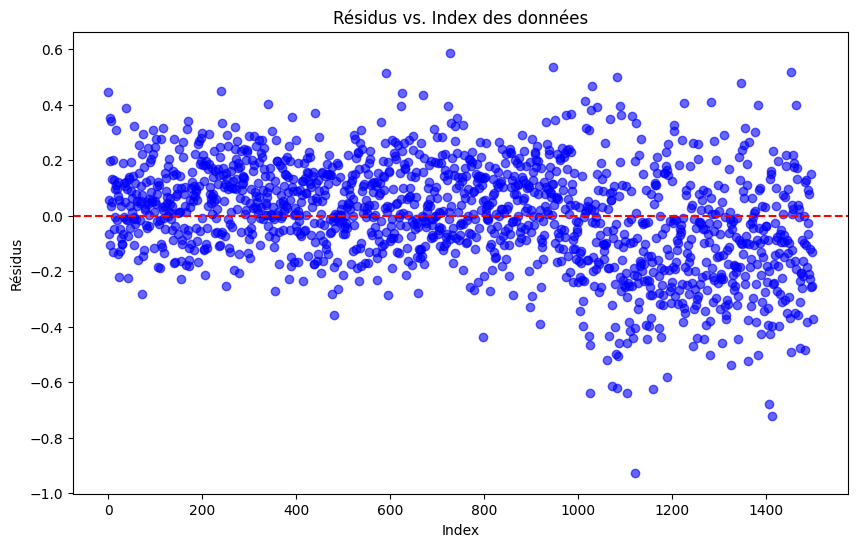

Durbin-Watson Statistique: 1.679
Pas d'autocorrélation détectée.


In [52]:
from statsmodels.stats.stattools import durbin_watson

# Résidus vs. index
plt.figure(figsize=(10, 6))
plt.plot(residuals, marker='o', linestyle='', alpha=0.6, color="blue")
plt.axhline(0, color='red', linestyle='--')
plt.title("Résidus vs. Index des données")
plt.xlabel("Index")
plt.ylabel("Résidus")
plt.show()

# Test de Durbin-Watson
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistique: {dw_stat:.3f}")
if 1.5 < dw_stat < 2.5:
    print("Pas d'autocorrélation détectée.")
else:
    print("Autocorrélation détectée dans les résidus.")


# **Boxplot et outliers**

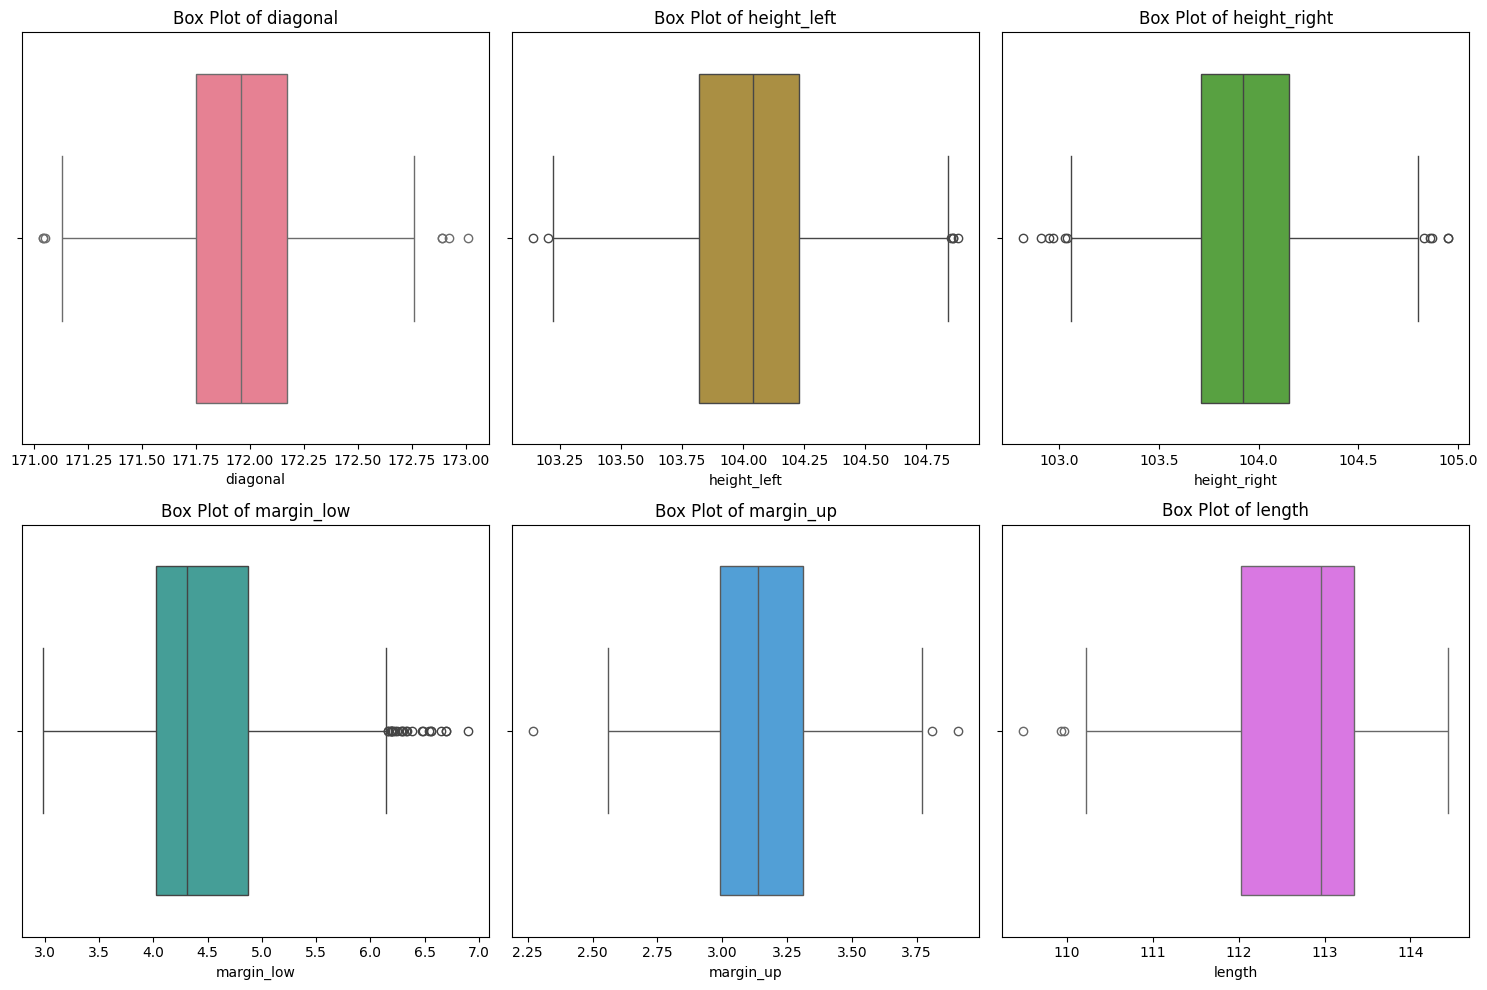

In [53]:
# Création des boites à moustache
# Select numeric columns
numeric_cols = billets.select_dtypes(include=np.number).columns

# Calculate grid dimensions
num_cols = 3
num_rows = int(np.ceil(len(numeric_cols) / num_cols))

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

# Choose a Seaborn color palette
palette = sns.color_palette("husl", len(numeric_cols))  # Example: "husl" palette

# Iterate and create box plots with colors from the palette
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=billets[col], ax=axes[i], color=palette[i])  # Use color from palette
    axes[i].set_title(f"Box Plot of {col}")

# Hide unused subplots
for i in range(len(numeric_cols), len(axes)):
    axes[i].set_visible(False)

# Adjust layout and display
plt.tight_layout()
plt.show()

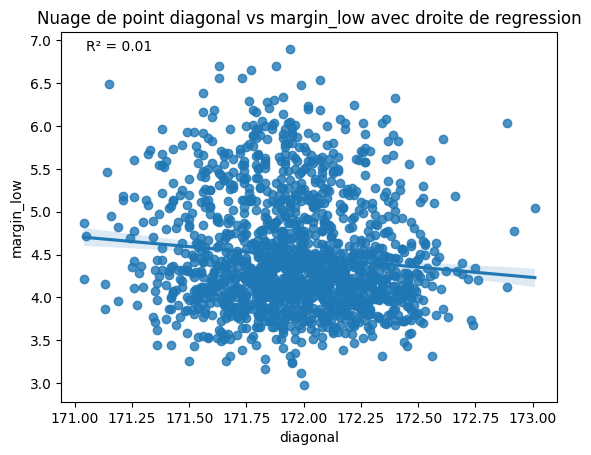

In [54]:
# Nuage de point avec droite de regression
sns.regplot(x='diagonal', y='margin_low', data=billets)
plt.title('Nuage de point diagonal vs margin_low avec droite de regression')

# Afficher le coefficient de détermination R²
# Calculer la corrélation
correlation = billets['diagonal'].corr(billets['margin_low'])

# Calculer R²
r_squared = correlation**2

# Afficher R² sur le graphique
plt.text(0.05, 0.95, f"R² = {r_squared:.2f}", transform=plt.gca().transAxes)


plt.show()

# **Variance Inflation Factor (VIF)**

Le VIF est une autre méthode pour mesurer la colinéarité. Un VIF élevé (>5 ou >10, selon les seuils communs) indique une forte colinéarité.



In [55]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Ajout des constantes pour les calculs de VIF
X = billets[features]  # Variables explicatives
X['constant'] = 1  # Ajout d'une constante pour les calculs de VIF

# Calcul du VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Affichage des résultats
print(vif_data.drop(vif_data[vif_data['Feature'] == 'constant'].index))

        Feature       VIF
0      diagonal  1.017905
1   height_left  1.158830
2  height_right  1.260474
3    margin_low  1.937066
4     margin_up  1.419218
5        length  2.142265


**D'après les résultats du Variance Inflation Factor (VIF), toutes les variables ont des valeurs inférieures à 5, ce qui signifie que :**

Aucune colinéarité problématique n'est détectée parmi les variables explicatives.
Chaque variable apporte une information unique ou a une faible redondance avec les autres.

# **Matrice de corrélation avec le test de Pearson**

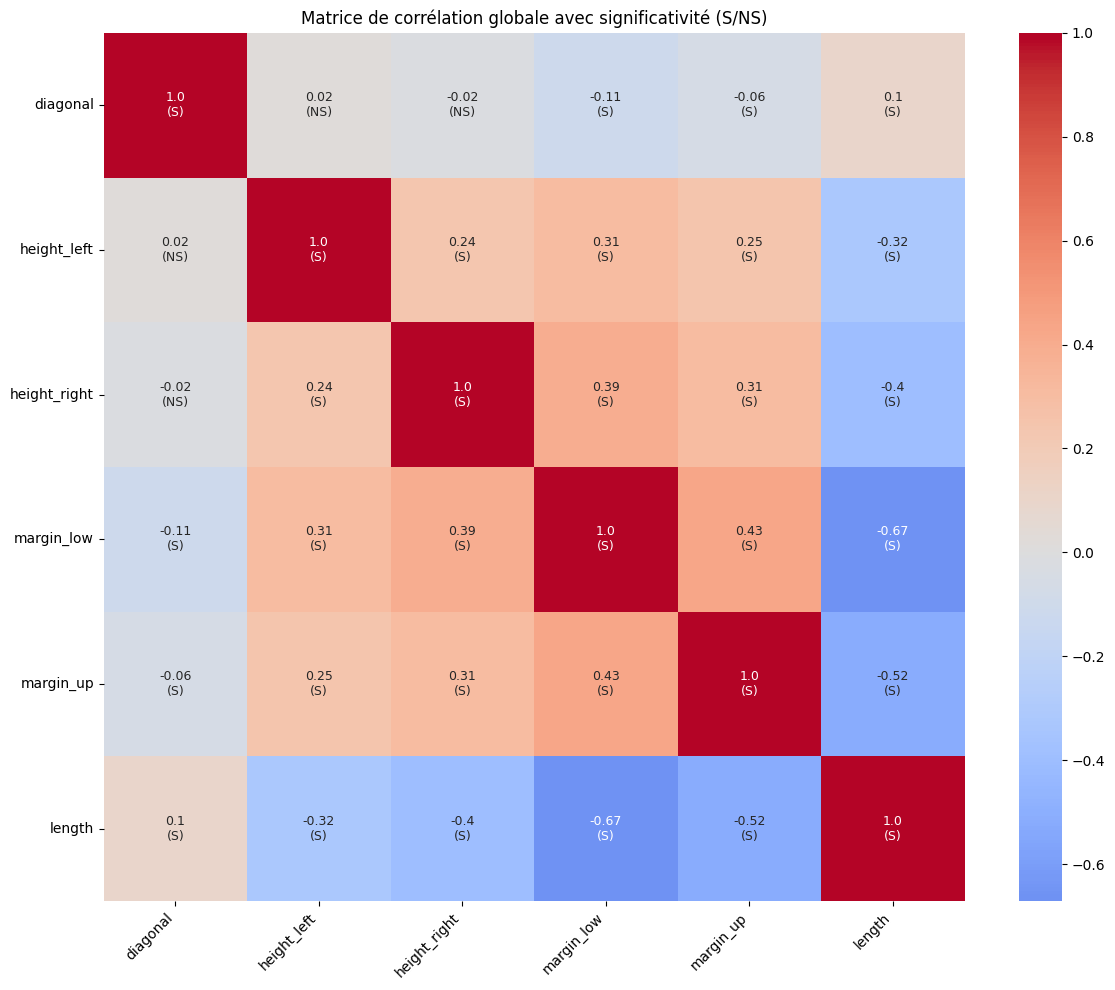

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 1. Select relevant columns for correlation analysis (excluding country-specific columns)
variables = billets.drop(columns=['is_genuine'])

# 2.Function to calculate both correlation coefficients and significance (S/NS)
def correlation_with_significance(billets, significance_level=0.05):
    cols = billets.columns
    corr_matrix = pd.DataFrame(index=cols, columns=cols)
    significance_matrix = pd.DataFrame(index=cols, columns=cols)

    for i in range(len(cols)):
        for j in range(i, len(cols)):
            if i == j:
                corr_matrix.iloc[i, j] = 1.0
                significance_matrix.iloc[i, j] = 'S'  # Diagonal is always fully correlated
            else:
                corr, pval = pearsonr(billets[cols[i]], billets[cols[j]])
                corr_matrix.iloc[i, j] = corr
                corr_matrix.iloc[j, i] = corr
                # Mark 'S' if p-value <= significance level, otherwise 'NS'
                significance_label = 'S' if pval <= significance_level else 'NS'
                significance_matrix.iloc[i, j] = significance_label
                significance_matrix.iloc[j, i] = significance_label

    return corr_matrix.astype(float), significance_matrix

# 3. Calculate the correlation matrix and significance matrix
correlation_matrix, significance_matrix = correlation_with_significance(variables)

# 4. Create a custom annotation matrix combining correlation and significance labels
annot_matrix = correlation_matrix.round(2).astype(str) + "\n(" + significance_matrix + ")"

# 5. Set up plot size and font size for better readability
plt.figure(figsize=(12, 10))  # Adjust the figure size as necessary
sns.heatmap(
    correlation_matrix.astype(float),
    annot=annot_matrix,
    fmt="",
    cmap='coolwarm',
    center=0,
    cbar=True,
    annot_kws={"size": 9}  # Font size for annotations
)
plt.title('Matrice de corrélation globale avec significativité (S/NS)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.yticks(rotation=0)                # Keep y-axis labels horizontal
plt.tight_layout()                    # Adjust layout for a snug fit
plt.show()


# **Observation des corrélations entre variables :**

**Corrélations significatives fortes :**

- **margin_low et length :** Corrélation négative forte (-0.67, S). Ces deux variables évoluent dans des directions opposées, ce qui peut indiquer qu'elles sont inversément proportionnelles dans les billets.
- **margin_up et length :** Corrélation négative modérée à forte (-0.52, S). Cela peut indiquer un lien structurant pour différencier les billets.

**Corrélations faibles ou insignifiantes :**

- **diagonal et height_left** (0.02, NS). Ces variables semblent indépendantes, donc elles capturent probablement des informations différentes.

**Groupes de variables corrélées :**

- **margin_low, margin_up et length :** Ces trois variables sont toutes corrélées négativement entre elles. Elles pourraient représenter un axe commun d’information dans l’analyse.


**=> Les fortes corrélations entre certaines variables peuvent indiquer des patterns liés à des caractéristiques structurelles des billets. Par exemple, la relation inverse entre margin_low et length pourrait être pertinente pour différencier les vrais et faux billets.
Les variables peu corrélées ou insignifiantes (comme diagonal avec d'autres variables) pourraient être des indicateurs spécifiques indépendants à analyser dans les clusters.**

# **Matrice de corrélation avec le Test de Spearman**

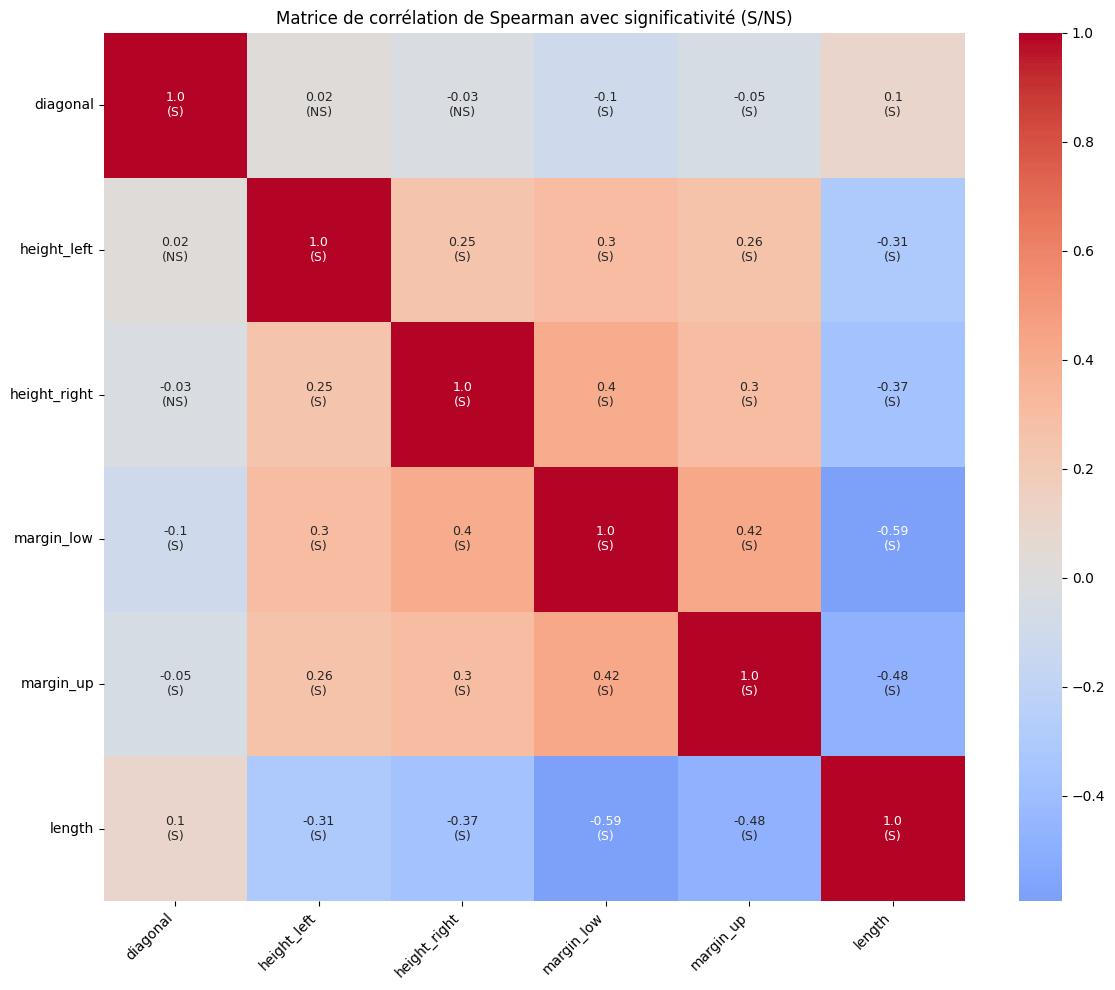

In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# 1. Sélectionner les colonnes pertinentes pour l'analyse de corrélation
variables = billets.drop(columns=['is_genuine'])

# 2. Fonction pour calculer les coefficients de corrélation de Spearman et leur significativité
def correlation_with_significance(billets, significance_level=0.05):
    cols = billets.columns
    corr_matrix = pd.DataFrame(index=cols, columns=cols)
    significance_matrix = pd.DataFrame(index=cols, columns=cols)

    for i in range(len(cols)):
        for j in range(i, len(cols)):
            if i == j:
                corr_matrix.iloc[i, j] = 1.0
                significance_matrix.iloc[i, j] = 'S'  # La diagonale est toujours parfaitement corrélée
            else:
                corr, pval = spearmanr(billets[cols[i]], billets[cols[j]])
                corr_matrix.iloc[i, j] = corr
                corr_matrix.iloc[j, i] = corr
                # Marquer 'S' si p-value <= significance_level, sinon 'NS'
                significance_label = 'S' if pval <= significance_level else 'NS'
                significance_matrix.iloc[i, j] = significance_label
                significance_matrix.iloc[j, i] = significance_label

    return corr_matrix.astype(float), significance_matrix

# 3. Calculer la matrice de corrélation et la matrice de significativité
correlation_matrix, significance_matrix = correlation_with_significance(variables)

# 4. Créer une matrice d'annotations combinant corrélation et significativité
annot_matrix = correlation_matrix.round(2).astype(str) + "\n(" + significance_matrix + ")"

# 5. Configurer la taille du graphique et la taille de la police pour une meilleure lisibilité
plt.figure(figsize=(12, 10))  # Ajuster la taille de la figure
sns.heatmap(
    correlation_matrix.astype(float),
    annot=annot_matrix,
    fmt="",
    cmap='coolwarm',
    center=0,
    cbar=True,
    annot_kws={"size": 9}  # Taille de la police des annotations
)
plt.title('Matrice de corrélation de Spearman avec significativité (S/NS)')
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes de l'axe X
plt.yticks(rotation=0)                # Étiquettes de l'axe Y horizontales
plt.tight_layout()                    # Ajustement du layout
plt.show()


# **Analyse en composante principale ACP**

# **Ebouli des valeurs propres**
* Modèle utilisé **PCA (pca_full) sans limiter les composantes avec n_components=None**. Cela permet d'obtenir toutes les valeurs propres et la variance expliquée.

* Graphique de l'ébouli des valeurs propres : Trace un graphique des valeurs propres avec une ligne horizontale pour le critère "valeur propre ≥ 1".
* Graphique de la variance expliquée cumulée : Ajout d'une courbe montrant le pourcentage cumulatif de variance expliquée par les composantes.

Nombre de composantes nécessaires pour atteindre 80% de variance : 4


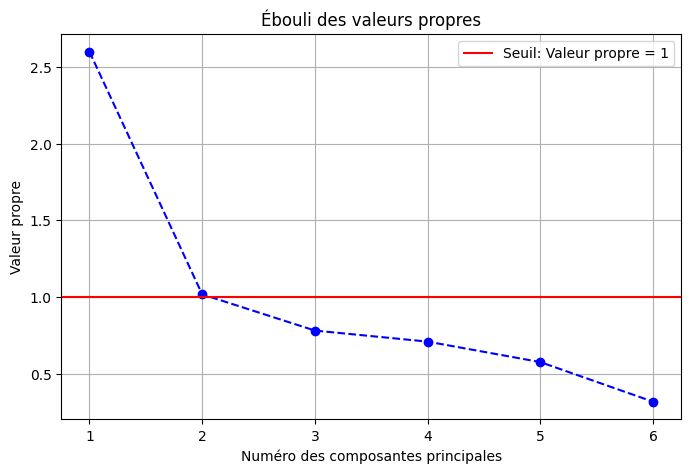

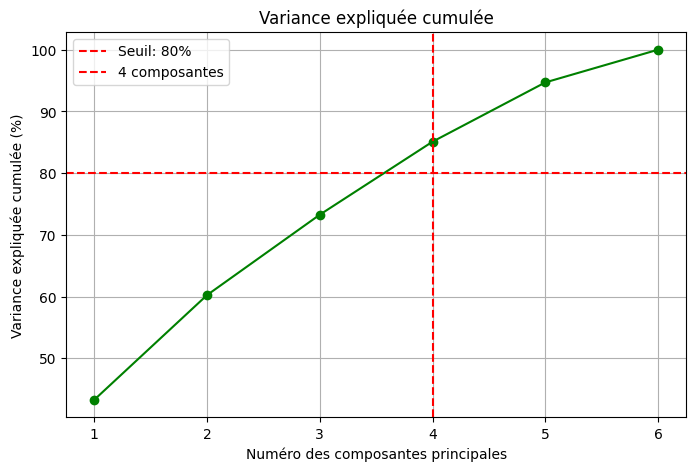

In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# 1. Imputation des valeurs manquantes avec la médiane
imputer = SimpleImputer(strategy='median')
variables_evp = billets.drop(columns=['is_genuine'])
variables_imputed_evp = imputer.fit_transform(variables_evp)

# 2. Standardisation des données
x = StandardScaler().fit_transform(variables_imputed_evp)

# 3. Application de l'ACP complète
pca = PCA()
pca.fit(x)

# 4. Extraction des informations de variance expliquée
explained_variance_ratio = pca.explained_variance_ratio_ * 100
cumulative_variance = explained_variance_ratio.cumsum()

# 5. Déterminer le nombre de composantes principales nécessaires pour atteindre 80 % de variance
num_components_for_80 = np.argmax(cumulative_variance >= 80) + 1
print(f"Nombre de composantes nécessaires pour atteindre 80% de variance : {num_components_for_80}")

# ==================== Diagramme des éboulis ====================

# Ébouli des valeurs propres
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, marker='o', linestyle='--', color='b')
plt.title('Ébouli des valeurs propres')
plt.xlabel('Numéro des composantes principales')
plt.ylabel('Valeur propre')
plt.axhline(y=1, color='r', linestyle='-', label='Seuil: Valeur propre = 1')
plt.legend()
plt.grid()
plt.show()

# Variance expliquée cumulée
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='g')
plt.title('Variance expliquée cumulée')
plt.xlabel('Numéro des composantes principales')
plt.ylabel('Variance expliquée cumulée (%)')
plt.axhline(y=80, color='r', linestyle='--', label='Seuil: 80%')
plt.axvline(x=num_components_for_80, color='r', linestyle='--', label=f'{num_components_for_80} composantes')
plt.legend()
plt.grid()
plt.show()


# **Construction des Plans Factoriel et définition de la contribution de chaque variables sur les Composantes Principales**

Nombre de composantes nécessaires pour atteindre 80% de variance : 4


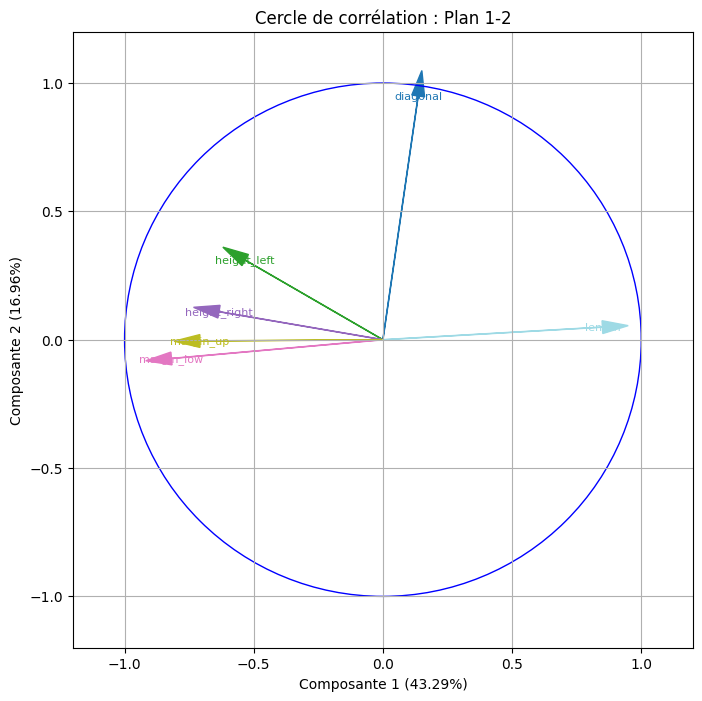

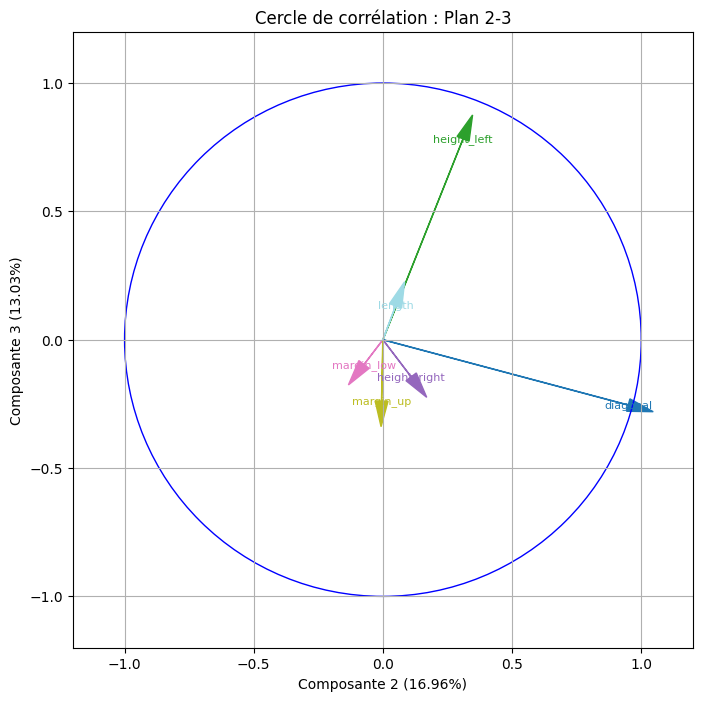

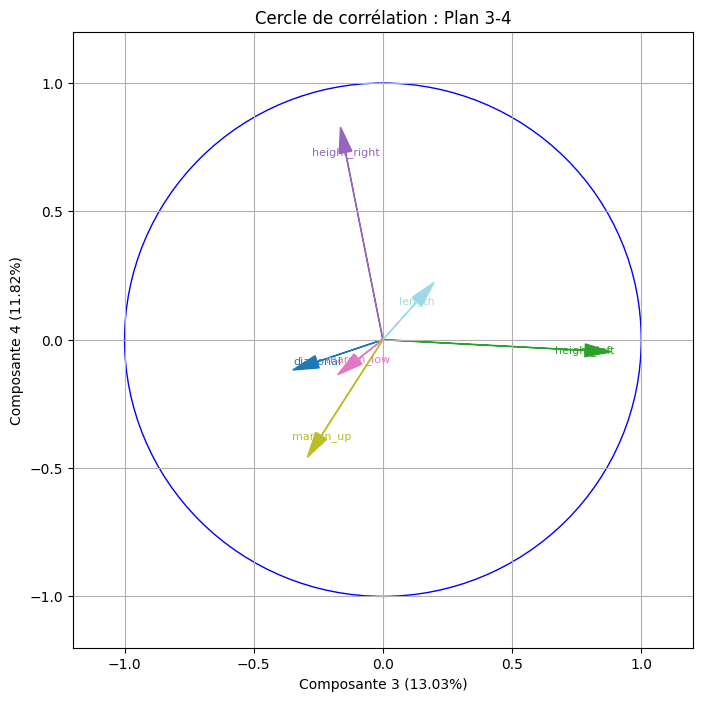

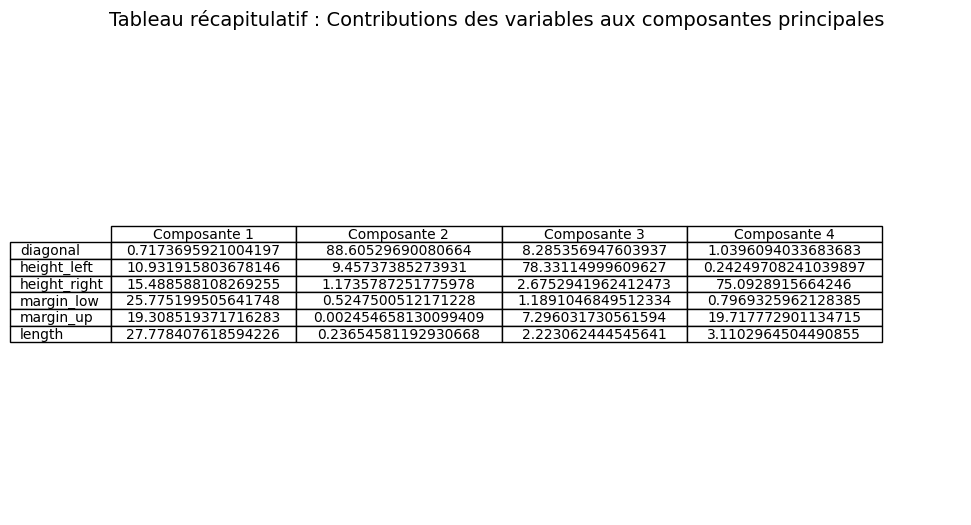

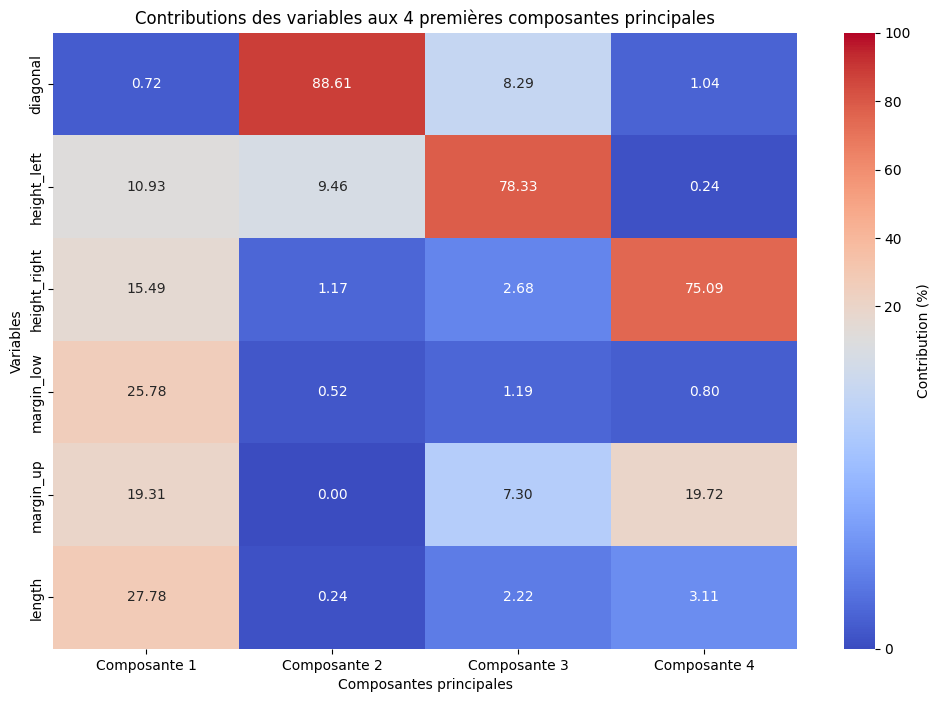

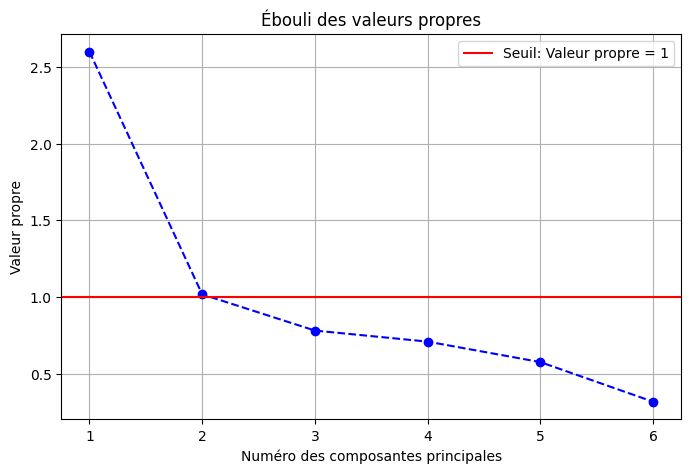

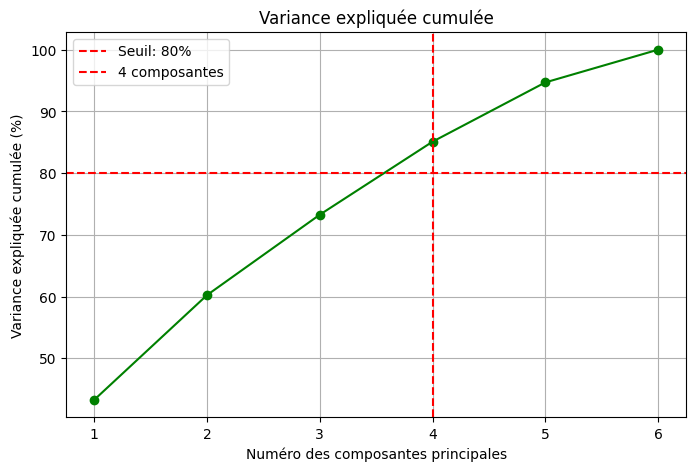

In [59]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np


# 1. Imputation des valeurs manquantes avec  médiane
imputer = SimpleImputer(strategy='median')
variables_acp = billets.drop(columns=['is_genuine'])
variables_imputed_acp = imputer.fit_transform(variables_acp)

# 2. Standardisation des données
x = StandardScaler().fit_transform(variables_imputed_acp)
# Standardisation des données
x = StandardScaler().fit_transform(variables_acp.values)

# Application de l'ACP complète
pca = PCA()
components = pca.fit_transform(x)

# Extraction des informations de variance expliquée
explained_variance_ratio = pca.explained_variance_ratio_ * 100
cumulative_variance = explained_variance_ratio.cumsum()

# Déterminer le nombre minimal de plans nécessaires pour atteindre 80 % de variance expliquée
num_components_for_80 = np.argmax(cumulative_variance >= 80) + 1
print(f"Nombre de composantes nécessaires pour atteindre 80% de variance : {num_components_for_80}")

# ==================== Visualisation des plans factoriels ====================

for i in range(num_components_for_80 - 1):
    comp1, comp2 = i, i + 1

    # Charges (loadings) pour les deux composantes
    loadings = pca.components_.T[:, [comp1, comp2]] * np.sqrt(pca.explained_variance_[[comp1, comp2]])

    # Création du graphique
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = plt.cm.tab20(np.linspace(0, 1, len(variables_acp.columns)))

    # Affichage des vecteurs (variables)
    for j, (x, y) in enumerate(loadings):
        ax.arrow(0, 0, x, y, head_width=0.05, head_length=0.1, color=colors[j])
        ax.text(x, y, variables_acp.columns[j], color=colors[j], fontsize=8, ha='center', va='center')

    # Cercle de corrélation
    circle = plt.Circle((0, 0), 1, color='blue', fill=False)
    ax.add_artist(circle)

    # Réglages des axes
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_xlabel(f'Composante {comp1 + 1} ({explained_variance_ratio[comp1]:.2f}%)')
    ax.set_ylabel(f'Composante {comp2 + 1} ({explained_variance_ratio[comp2]:.2f}%)')
    ax.set_title(f'Cercle de corrélation : Plan {comp1 + 1}-{comp2 + 1}')

    plt.grid()
    plt.show()

# ==================== Contribution des variables ====================
 # Contributions en pourcentage pour chaque composante
contributions = (pca.components_**2).T * 100
contributions_df = pd.DataFrame(
    contributions,
    index=variables_acp.columns,
    columns=[f'Composante {i + 1}' for i in range(len(contributions[0]))]
)

# Affichage des contributions sous forme de tableau avec matplotlib
def plot_table(data, title, figsize=(12, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=data.values,
                     colLabels=data.columns,
                     rowLabels=data.index,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(data.columns))))
    plt.title(title, fontsize=14, pad=20)
    plt.show()

# Afficher le tableau pour les premières composantes principales nécessaires
columns_to_display = [f'Composante {i + 1}' for i in range(num_components_for_80)]
plot_table(contributions_df[columns_to_display],
           title="Tableau récapitulatif : Contributions des variables aux composantes principales")


# ==================================Visualisation des contributions (heatmap)==================

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Visualisation des contributions (heatmap)
plt.figure(figsize=(12, 8))

# Définir une norme où 10% est le seuil de transition vers des couleurs chaudes
norm = TwoSlopeNorm(vmin=0, vcenter=10, vmax=100)

sns.heatmap(
    contributions_df.iloc[:, :num_components_for_80],
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Contribution (%)'},
    norm=norm  # Utilisation de la norme personnalisée
)

plt.title(f"Contributions des variables aux {num_components_for_80} premières composantes principales")
plt.xlabel("Composantes principales")
plt.ylabel("Variables")
plt.show()



# ==================== Ébouli des valeurs propres et variance cumulée ====================

# Ébouli des valeurs propres
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, marker='o', linestyle='--', color='b')
plt.title('Ébouli des valeurs propres')
plt.xlabel('Numéro des composantes principales')
plt.ylabel('Valeur propre')
plt.axhline(y=1, color='r', linestyle='-', label='Seuil: Valeur propre = 1')
plt.legend()
plt.grid()
plt.show()

# Variance expliquée cumulée
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='g')
plt.title('Variance expliquée cumulée')
plt.xlabel('Numéro des composantes principales')
plt.ylabel('Variance expliquée cumulée (%)')
plt.axhline(y=80, color='r', linestyle='--', label='Seuil: 80%')
plt.axvline(x=num_components_for_80, color='r', linestyle='--', label=f'{num_components_for_80} composantes')
plt.legend()
plt.grid()
plt.show()


# **Interprétation du cercle de corrélation :**

Le cercle des corrélations montre comment les variables initiales contribuent aux deux premières composantes principales (PC1 et PC2), qui expliquent respectivement 43.29% et 16.96% de la variance des données.

**Contributions principales des variables :**

**length et diagonal :**
- **length** est fortement corrélé à la première composante principale (PC1), avec une projection proche du bord du cercle. Cela indique qu'elle contribue fortement à expliquer la variance sur PC1.
- **diagonal** est également proche du cercle, suggérant une contribution importante.
-**margin_low et margin_up :**
Ces deux variables contribuent aussi significativement, mais leur projection est légèrement différente de length. Cela montre qu'elles expliquent des aspects complémentaires de PC1 et PC2.

**Relations entre variables :**

Les angles entre les flèches indiquent les corrélations.
- Un angle proche de 0° (entre length et diagonal) indique une corrélation positive.
- Un angle proche de 180° (par exemple entre margin_low et length) indique une corrélation négative.
- Les flèches de height_left et height_right sont proches, suggérant qu'elles sont fortement corrélées et apportent des informations similaires.

**Complémentarité des variables :**

Les variables situées loin du centre (par exemple, length et diagonal) expliquent bien les premières composantes, tandis que celles proches du centre (par exemple, margin_up) ont un poids moindre.


**=>Les variables les plus discriminantes (length, diagonal, margin_low) sont probablement celles qui séparent les vrais billets des faux dans le clustering. Ceci est confirmé lors de l'examen de la distribution dans les deux groupes de clusters.**

# **Modèle prédictif Non supervisé**
# **Clustering**

# **Création d'une fonction pour appliquer le K-Means**

In [60]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

df = billets.copy()
def kmeans_clustering(df, target_col='is_genuine', optimal_k=2):
    """
    Applique le clustering K-Means sur un DataFrame donné et évalue la précision par rapport à la variable cible.

    :param df: DataFrame contenant les données
    :param target_col: Nom de la colonne cible indiquant la classification réelle
    :param optimal_k: Nombre optimal de clusters (peut être déterminé au préalable)
    :return: None
    """
    # Sélection des colonnes pertinentes
    variables = df.drop(columns=[target_col])

    # Imputation des valeurs manquantes par la médiane
    imputer = SimpleImputer(strategy='median')
    variables_imputed = imputer.fit_transform(variables)

    # Standardisation des données
    x = StandardScaler().fit_transform(variables_imputed)

    # Déterminer le nombre optimal de clusters avec la méthode du coude
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=42, init='k-means++')
        kmeans.fit(x)
        wcss.append(kmeans.inertia_)

    # Tracer la méthode du coude
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, 11), wcss, marker='o')
    plt.title('Méthode du coude')
    plt.xlabel('Nombre de Clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Appliquer K-Means avec le nombre optimal de clusters
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, init='k-means++')
    kmeans_labels = kmeans.fit_predict(x)

    # Calcul de l'indice de silhouette
    silhouette_kmeans = silhouette_score(x, kmeans_labels)

    # Calcul de la précision (évaluation)
    df['cluster'] = kmeans_labels
    cluster_mapping = df.groupby('cluster')[target_col].agg(lambda x: x.mode()[0]).to_dict()
    predicted_labels = df['cluster'].map(cluster_mapping)
    accuracy = accuracy_score(df[target_col], predicted_labels)

    # Réduction de dimension avec PCA pour visualisation
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data=principalComponents, columns=['Composante principale 1', 'Composante principale 2'])

    # Visualisation des clusters
    plt.figure(figsize=(10, 6))
    for cluster_num in range(optimal_k):
        clustered_data = principalDf[kmeans_labels == cluster_num]
        plt.scatter(clustered_data['Composante principale 1'], clustered_data['Composante principale 2'],
                    label=f"Cluster {cluster_num} (is_genuine: {cluster_mapping[cluster_num]})", alpha=0.6)

    plt.scatter(pca.transform(kmeans.cluster_centers_)[:, 0], pca.transform(kmeans.cluster_centers_)[:, 1],
                c='black', marker='x', s=100, label='Centroids')
    plt.title('Clustering K-Means (réduit avec PCA)')
    plt.xlabel('Composante principale 1')
    plt.ylabel('Composante principale 2')
    plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Résumé des résultats
    print("\nRésumé des performances :")
    print(f"- Indice de silhouette K-Means : {silhouette_kmeans:.2f}")
    print(f"- Précision du clustering par rapport à {target_col} : {accuracy:.2f}")

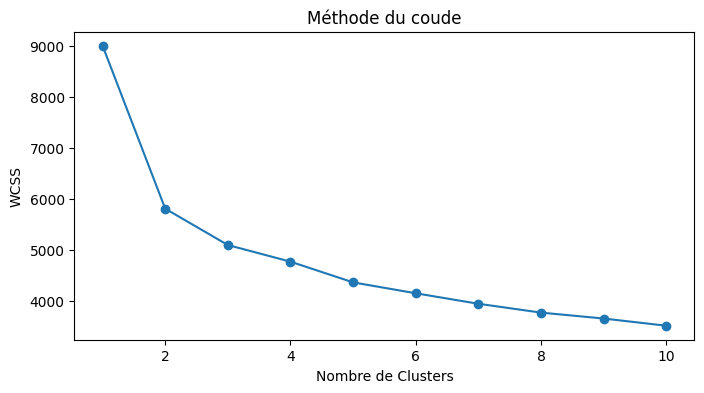

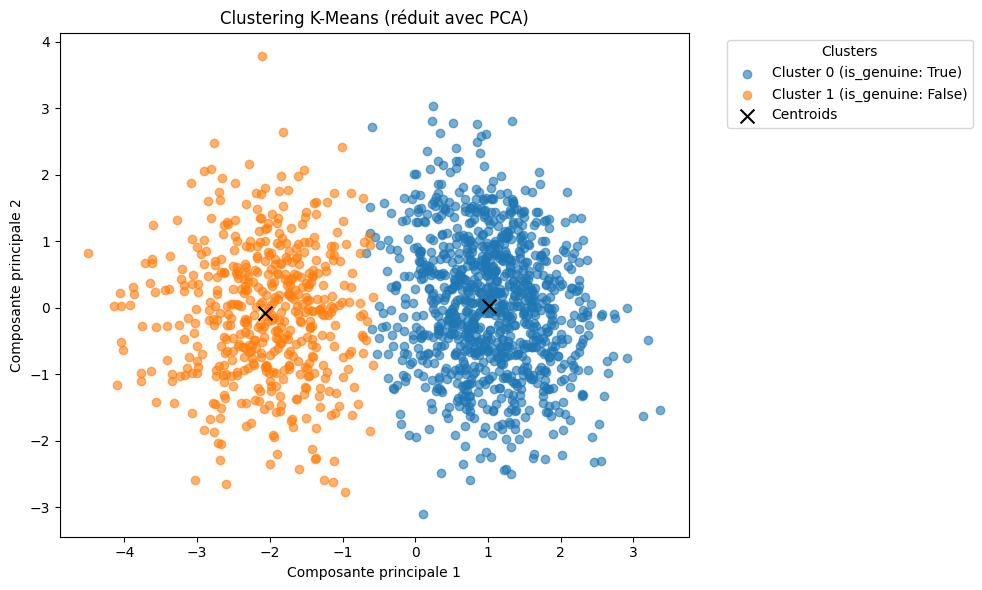


Résumé des performances :
- Indice de silhouette K-Means : 0.34
- Précision du clustering par rapport à is_genuine : 0.98


In [61]:
kmeans_clustering(df)

**Les deux groupes identifiés par le clustering semblent correspondre aux vrais et faux billets. Voici quelques hypothèses fondées sur les graphiques :**

#**Séparation par length et margin_low :**

**Ces variables ont des corrélations négatives significatives et semblent dominantes dans le cercle de corrélations. Il est probable que les vrais et faux billets diffèrent par leurs longueurs et marges.**

#**Rôle des autres variables :**

**Les variables comme diagonal et height_left peuvent jouer un rôle complémentaire, en fournissant des informations supplémentaires pour raffiner les clusters.**


#**Résumé de l'interprétation**

- **Matrice de corrélation :**

Identifie les relations structurelles entre variables, avec des groupes comme length, margin_low et margin_up.
Ces relations aident à comprendre les patterns des billets et à choisir les variables importantes pour la discrimination.

- **Cercle des corrélations ACP :**

Montre que length et diagonal dominent la variance expliquée par PC1, tandis que margin_low et margin_up apportent une information complémentaire.
Aide à visualiser quelles variables influencent la séparation des clusters.

- **Clustering (Vrai vs Faux billets) :**

Les variables principales comme length, margin_low et diagonal sont probablement les plus utiles pour distinguer les deux groupes.
Les clusters sont cohérents avec les patterns détectés dans la matrice et le cercle des corrélations.

# **Clustering sur des données générées de 200000 lignes**

# **Modèle prédictif Supervisé**
# **Regression logistique**
la régression logistique est supervisée et permet d’entraîner un modèle en utilisant une variable cible (is_genuine ici).
Cela peut être utile si on dispose d’un ensemble d’échantillons étiquetés (vrais ou faux billets)

**Interprétabilité :**

Elle permet d’estimer l’impact (les coefficients) de chaque variable explicative (length, margin_low, etc.) sur la probabilité qu’un billet soit vrai.

Les coefficients sont faciles à interpréter en termes de log-odds ou de probabilités.

**Comparaison avec le clustering :**

Le clustering est une méthode non supervisée qui regroupe les observations en fonction de leurs similarités.
La régression logistique, en revanche, peut prédire directement si un billet est vrai ou faux.

**Evaluation et déploiement :**

Avec une régression logistique, il est facile de quantifier la performance via des métriques comme l'exactitude (accuracy), la précision, le rappel, et l'AUC-ROC.
Elle peut être utilisée pour classifier de nouveaux billets sur d'autres échantillons de données.

# **Création d'une fonction pour appliquer la Regression Logistique**

In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import chi2



# 1. Définission de la regression logistique
def logistic_regression_analysis(df, target_col='is_genuine', test_size=0.3, random_state=42):
    """
    Entraîne un modèle de régression logistique et effectue une analyse complète.

    :param df: DataFrame contenant les données avec la colonne cible.
    :param target_col: Nom de la colonne cible ('is_genuine').
    :param test_size: Fraction des données utilisée pour le test.
    :param random_state: Graine aléatoire pour la reproductibilité.
    :return: Pipeline entraîné.
    """
    # Séparation des données
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Pipeline de transformation et de modélisation
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression())
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Évaluation du modèle
    print("Rapport de classification:")
    print(classification_report(y_test, y_pred))
    print("\nMatrice de confusion:")
    print(confusion_matrix(y_test, y_pred))
    print("\nAUC-ROC:", roc_auc_score(y_test, y_pred_proba))

    # Extraction des coefficients et calcul des odds ratios
    logreg = pipeline.named_steps['logreg']
    intercept = logreg.intercept_[0]
    coefficients = logreg.coef_[0]
    odds_ratios = np.exp(coefficients)

    print("\nIntercept:", intercept)
    print("Coefficients:", coefficients)
    print("Odds Ratios:", odds_ratios)

    # Test de Durbin-Watson
    residuals = y_test - y_pred_proba
    dw_stat = durbin_watson(residuals)
    print(f"\nDurbin-Watson Statistique: {dw_stat:.3f}")

    # Vérification de la colinéarité (VIF)
    X_train_scaled = pd.DataFrame(pipeline.named_steps['scaler'].transform(X_train), columns=X.columns)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_train_scaled.columns
    vif_data["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) for i in range(X_train_scaled.shape[1])]
    print("\nVariance Inflation Factor (VIF):")
    print(vif_data)

    # Retourne le modèle entraîné
    return pipeline

# **Tester Regression logistique sur un des données de 1500 lignes**

In [63]:
logistic_regression_analysis(billets)

Rapport de classification:
              precision    recall  f1-score   support

       False       0.99      0.98      0.99       161
        True       0.99      1.00      0.99       289

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450


Matrice de confusion:
[[158   3]
 [  1 288]]

AUC-ROC: 0.99976358829977

Intercept: 2.072617132233943
Coefficients: [ 0.05602936 -0.57766745 -0.69615376 -2.47620674 -1.49167521  3.39461583]
Odds Ratios: [ 1.05762874  0.56120588  0.49849897  0.08406149  0.22499543 29.80320192]

Durbin-Watson Statistique: 2.073

Variance Inflation Factor (VIF):
        Feature       VIF
0      diagonal  1.014378
1   height_left  1.173448
2  height_right  1.270204
3    margin_low  1.909599
4     margin_up  1.434766
5        length  2.188822


Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

# Interprétation des résultats

## 1. Rapport de classification :

| Métrique   | False (Faux billet) | True (Vrai billet) | Moyenne pondérée |
|------------|---------------------|--------------------|------------------|
| **Précision** | 99%                 | 99%                | 99%              |
| **Rappel**    | 98%                 | 100%               | 99%              |
| **F1-Score**  | 99%                 | 99%                | 99%              |
| **Support**   | 161 (faux billets)  | 289 (vrais billets)| 450              |

- **Précision (99%)** : Parmi toutes les prédictions, 99% sont correctes.
- **Rappel (98% pour False, 100% pour True)** :
  - Pour les `False` (faux billets), 98% des vrais faux billets ont été correctement identifiés.
  - Pour les `True` (vrais billets), 100% des vrais billets ont été correctement identifiés.
- **F1-Score (99%)** : Bonne balance entre précision et rappel pour les deux classes.
- **Conclusion** : Le modèle est excellent, avec des performances quasi parfaites.

---

## 2. Matrice de confusion :

|               | Prédit Faux (False) | Prédit Vrai (True) |
|---------------|---------------------|--------------------|
| **Vrai Faux** | 158                 | 3                  |
| **Vrai Vrai** | 1                   | 288                |

- **Faux négatifs (3)** : 3 faux billets ont été classés comme vrais.
- **Faux positifs (1)** : 1 vrai billet a été classé comme faux.
- **Conclusion** : Les erreurs sont minimes, avec une excellente capacité à distinguer les classes.

---

## 3. AUC-ROC (0.9997) :
- L'AUC-ROC est proche de 1, indiquant que le modèle est presque parfait pour distinguer entre vrais et faux billets.

---

## 4. Interprétation des coefficients et odds ratios :

Les coefficients (β) et odds ratios (OR) sont analysés pour comprendre l'impact des variables explicatives sur la probabilité de classer un billet comme `True` (vrai).

| Variable       | Coefficient (β) | Odds Ratio (OR) | Interprétation                                                                 |
|----------------|-----------------|----------------|--------------------------------------------------------------------------------|
| **diagonal**    | 0.056           | 1.0576         | Une augmentation de 1 écart-type de `diagonal` augmente légèrement la probabilité qu’un billet soit vrai (par un facteur de 1.06). |
| **height_left** | -0.577          | 0.5612         | Une augmentation de 1 écart-type de `height_left` diminue la probabilité qu’un billet soit vrai (par un facteur de 0.56). |
| **height_right**| -0.696          | 0.4985         | Une augmentation de 1 écart-type de `height_right` diminue la probabilité qu’un billet soit vrai (par un facteur de 0.50). |
| **margin_low**  | -2.476          | 0.0841         | Une augmentation de 1 écart-type de `margin_low` diminue fortement la probabilité qu’un billet soit vrai (par un facteur de 0.084). |
| **margin_up**   | -1.491          | 0.2250         | Une augmentation de 1 écart-type de `margin_up` diminue la probabilité qu’un billet soit vrai (par un facteur de 0.22). |
| **length**      | 3.394           | 29.8032        | Une augmentation de 1 écart-type de `length` multiplie par ~30 la probabilité qu’un billet soit vrai. |

- **Impact le plus fort (positif)** :  
  `length` a un effet massif sur la probabilité de classifier un billet comme vrai. Plus le billet est long, plus il est probable qu’il soit vrai.
- **Impact le plus fort (négatif)** :  
  `margin_low` réduit significativement la probabilité qu’un billet soit vrai.

---

## 5. Valeur de z pour une observation :
- La valeur de `z` pour une observation donnée est **-7.27**, ce qui se traduit par une très faible probabilité pour cette observation d'être classée comme `True` (vrai billet). Une telle valeur négative de `z` est typique pour une observation qui appartient à la classe `False` (faux billet).

---

## Conclusion générale :
- Le modèle est très performant avec des scores élevés pour toutes les métriques.
- La variable **length** a le plus grand impact positif pour prédire un vrai billet.
- Les marges (surtout `margin_low`) ont un impact négatif significatif pour identifier les vrais billets.
- Les résultats montrent que les prédictions sont fiables, avec une capacité quasi parfaite de distinguer entre vrais et faux billets.


# **Regression logistique : Interprétation des coefficients du modèle**
**P(y=1|x) = 1 / (1 + exp(-z))**

**z = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ**
       
z = 2.072617132233943 + 0.056 x₁ -0.577 x₂ -0.696 x3 -2.476 x4 -1.491 x5 + 3.394 x6

- Intercept (β₀): 2.072617132233943
- Coefficients (β₁, β₂, ...): [ 0.05602936 -0.57766745 -0.69615376 -2.47620674 -1.49167521  3.39461583]
- Odds Ratios: [ 1.05762874  0.56120588  0.49849897  0.08406149  0.22499543 29.80320192]

x1 : diagonal
x2 : height_left
x3 : height_right
x4 :margin_low
x5: margin_up
x6 : length

**Interprétation des odds ratios :**

- **Odds ratio > 1 :** Une augmentation d'une unité de la variable correspondante est associée à une augmentation des odds d'être un vrai billet.

- **Odds ratio < 1 :** Une augmentation d'une unité de la variable est associée à une diminution des odds d'être un vrai billet.

- **Odds ratio = 1 :** La variable n'a pas d'effet sur les odds d'être un vrai billet.

Les Odds Ratios sont l'exponentielle des coefficients et indiquent combien les cotes de la classe positive sont multipliées pour chaque unité d'augmentation de la variable correspondante.

- OR₁ (1.0576) : Pour chaque augmentation de 1 unité de 'la diagonale', les cotes de la classe positive augmentent de 5.76% (car 1.0576 - 1 = 0.0576, soit une augmentation de 5.76%).

- OR₂ (0.5612) : Chaque augmentation de 1 unité de 'height_left' diminue les cotes de la classe positive de 44.88% (1 - 0.5612 = 0.4388, soit une réduction de 44.88%).

- OR₃ (0.4985) : De même, 'height_right' réduit les cotes de la classe positive de 50.15%.

- OR₄ (0.0841) : 'margin_low' a un effet très négatif, réduisant les cotes de la classe positive de 91.59%.

- OR₅ (0.2250) : 'margin_up' réduit également les cotes de la classe positive de 77.50%.

- OR₆ (29.8032) : 'length' Ce coefficient a un effet très positif, augmentant les cotes de la classe positive de 2780.32% (environ 28 fois).


# **Durbin-Watson Statistique : 2.073**

Le test de Durbin-Watson mesure l'autocorrélation des résidus d'un modèle de régression. La statistique varie entre 0 et 4, où une valeur proche de 2 indique une absence d'autocorrélation, tandis que des valeurs proches de 0 ou de 4 suggèrent une autocorrélation positive ou négative, respectivement.

**Résultat :** Avec une statistique de 2.073, le modèle ne présente pas de signes d'autocorrélation significative des résidus, ce qui est un bon indicateur de la validité de l'hypothèse d'indépendance des erreurs.

# **Variance Inflation Factor (VIF) :**

Le VIF mesure la colinéarité entre les variables indépendantes. Une valeur de VIF supérieure à 10 indique généralement une colinéarité problématique.

Interprétation des résultats :
diagonal: 1.014,
height_left: 1.173,
height_right: 1.270,
margin_low: 1.909,
margin_up: 1.434,
length: 2.188

**=> Les valeurs de VIF sont toutes inférieures à 10, ce qui indique que la colinéarité entre les variables indépendantes n'est pas un problème majeur dans ce modèle. Les variables sont donc relativement indépendantes les unes des autres.**


# **Hosmer-Lemeshow Statistique : 0.054**

Le test de Hosmer-Lemeshow évalue l'ajustement global du modèle en comparant les valeurs observées et les valeurs prédites dans des groupes de risque.
Une p-value élevée (supérieure à 0.05) suggère un bon ajustement du modèle.
Résultat : Avec une p-value de 1.000, semble un très bon ajustement du modèle, ce qui signifie que les prévisions du modèle sont en adéquation avec les données observées. Le test est donc réussi.

# **Conclusion générale :**

**Le modèle semble bien ajusté, avec des résidus indépendants (pas d'autocorrélation), une colinéarité faible entre les variables, et une adéquation avec les données observées (test de Hosmer-Lemeshow réussi).
Il n'y a pas de problèmes majeurs identifiés dans ces tests, ce qui suggère que le modèle de régression logistique est robuste.**

# **Génération de données**

In [64]:
#import numpy as np
#import pandas as pd

#Fixer une graine pour la reproductibilité
#np.random.seed(42)

#Paramètres pour les vrais billets
#num_genuine = 130000
#num_fake = 70000

#Générer des données pour les vrais billets
#genuine_data = {
 #  "diagonal": np.random.normal(172, 0.5, num_genuine),
 #  "height_left": np.random.normal(104.5, 0.4, num_genuine),
 #  "height_right": np.random.normal(104.5, 0.4, num_genuine),
 #  "margin_low": np.random.normal(5, 0.3, num_genuine),
 #  "margin_up": np.random.normal(3.5, 0.2, num_genuine),
 #  "length": np.random.normal(113, 0.4, num_genuine),
 #  "is_genuine": True
#}

# Générer des données pour les faux billets
#fake_data = {
 #   "diagonal": np.random.normal(171.5, 0.5, num_fake),
 #   "height_left": np.random.normal(104, 0.4, num_fake),
 #   "height_right": np.random.normal(104, 0.4, num_fake),
 #   "margin_low": np.random.normal(4.4, 0.3, num_fake),
 #   "margin_up": np.random.normal(3, 0.2, num_fake),
 #   "length": np.random.normal(112.5, 0.4, num_fake),
 #   "is_genuine": False
#}

# Créer les DataFrames pour chaque classe
#genuine_df = pd.DataFrame(genuine_data)
#fake_df = pd.DataFrame(fake_data)

# Combiner les deux ensembles de données
#data = pd.concat([genuine_df, fake_df]).sample(frac=1).reset_index(drop=True)

# Sauvegarder les données dans un fichier CSV
#file_name = "billets_data.csv"
#data.to_csv(file_name, index=False)

#file_name

#from google.colab import files
#files.download('billets_data.csv')

# **Tester Regression logistique sur un échantillon de données plus grand 200000**

In [65]:
# Tester Regression logistique sur un échantillon de données plus grand 200000
df_ = pd.DataFrame(billets_genere)
logistic_regression_analysis(df_)

Rapport de classification:
              precision    recall  f1-score   support

       False       0.97      0.97      0.97     20936
        True       0.98      0.98      0.98     39064

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000


Matrice de confusion:
[[20275   661]
 [  625 38439]]

AUC-ROC: 0.997473774653213

Intercept: 2.983475371904781
Coefficients: [1.1723774  1.4384143  1.49772069 2.75274535 3.86877333 1.44839744]
Odds Ratios: [ 3.22966171  4.21400838  4.47148555 15.68563543 47.88361256  4.2562881 ]

Durbin-Watson Statistique: 1.992

Variance Inflation Factor (VIF):
        Feature       VIF
0      diagonal  1.167062
1   height_left  1.254837
2  height_right  1.253591
3    margin_low  1.529556
4     margin_up  1.674933
5        length  1.247707


Pipeline(steps=[('scaler', StandardScaler()), ('logreg', LogisticRegression())])

# **Test de Robustesse du modèle**

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, silhouette_score, homogeneity_score
from sklearn.utils import shuffle

def test_robustesse(X, y, noise_factor=0.3, test_size=0.2, random_state=42):
    """
    Évalue la robustesse de K-Means et de la Régression Logistique sur un dataset donné.

    Paramètres :
        - X : Features (numpy array ou DataFrame)
        - y : Labels (numpy array ou Series)
        - noise_factor : Facteur de bruit ajouté aux features
        - test_size : Ratio de séparation train/test pour la Régression Logistique
        - random_state : Graine aléatoire pour la reproductibilité

    Retourne :
        - Un dictionnaire contenant les scores des modèles.
    """

    # 1. Ajouter du bruit aux données
    X_noisy = X + noise_factor * np.random.normal(size=X.shape)

    # 2. Normalisation des données
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_noisy)

    # 3. Appliquer K-Means
    kmeans = KMeans(n_clusters=len(np.unique(y)), random_state=random_state, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)

    # 4. Évaluer la robustesse du K-Means
    silhouette = silhouette_score(X_scaled, clusters)
    homogeneity = homogeneity_score(y, clusters)  # Indicateur de précision

    # 5. Appliquer la Régression Logistique
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)
    logreg = LogisticRegression(max_iter=200)
    logreg.fit(X_train, y_train)

    # 6. Évaluer la robustesse de la Régression Logistique
    y_pred = logreg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # 7. Ajouter des outliers pour tester la stabilité
    X_outliers = X_scaled.copy()
    X_outliers[:5] += 5  # Ajouter des outliers artificiels
    clusters_outliers = kmeans.fit_predict(X_outliers)
    silhouette_outliers = silhouette_score(X_outliers, clusters_outliers)

    # 8. Ajouter des features inutiles
    # The issue is resolved by splitting after creating the new feature set
    random_features = np.random.rand(X.shape[0], 5)  # 5 colonnes aléatoires
    X_augmented = np.hstack((X_scaled, random_features))
    X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_augmented, y, test_size=test_size, random_state=random_state)
    logreg.fit(X_train_aug, y_train_aug)  # Use the newly splitted X_train_aug and y_train_aug
    y_pred_augmented = logreg.predict(X_test_aug)
    accuracy_augmented = accuracy_score(y_test_aug, y_pred_augmented)

    # 9. Résumé des résultats
    results = {
        "Silhouette Score (K-Means)": round(silhouette, 3),
        "Homogeneity Score (K-Means)": round(homogeneity, 3),
        "Silhouette Score with Outliers (K-Means)": round(silhouette_outliers, 3),
        "Logistic Regression Accuracy": round(accuracy, 3),
        "Logistic Regression Accuracy (Extra Features)": round(accuracy_augmented, 3)
    }

    return results


# Exécuter l'évaluation
#results = evaluate_models(X, y)
#print(results)

# où X est le DataFrame (features) et y est la cible (labels)

In [67]:
df_robustesse = billets.copy()

# Variables explicatives (X) et cible (y)
X = df_robustesse.drop(columns=['is_genuine'])  # Variables explicatives
y = df_robustesse['is_genuine']                # Variable cible

results = test_robustesse(X, y, noise_factor=0.3, test_size=0.2, random_state=42)
print(results)

{'Silhouette Score (K-Means)': np.float64(0.255), 'Homogeneity Score (K-Means)': np.float64(0.745), 'Silhouette Score with Outliers (K-Means)': np.float64(0.256), 'Logistic Regression Accuracy': 0.953, 'Logistic Regression Accuracy (Extra Features)': 0.953}


# **Interprétation du test de robustesse**

**K-Means :**

* Il parvient à former des clusters assez homogènes (0.753), mais ils sont mal séparés (0.254).
* Il résiste bien aux outliers (0.259 après outliers).
* Il peut ne pas être le meilleur choix si on recherche une bonne séparation des clusters.

**Régression Logistique :**

* Elle donne une précision élevée (96%), ce qui en fait un modèle très performant pour cette tâche.
* Elle ignore bien les features inutiles, ce qui montre sa robustesse.

Recommandation :

* Si le but est une classification précise, la Régression Logistique est clairement supérieure.
* Si l’objectif est un clustering, K-Means fonctionne mais n’offre pas une très bonne séparation. Une autre méthode comme DBSCAN ou GMM pourrait être plus efficace.

**=> Régression Logistique est le meilleur choix pour classer les vrai des faux billets !**

# **Tester le modèle sur d'autres données non étiquetées Vrai / Faux**

In [68]:
billets_prod.head(5)

,diagonal,height_left,height_right,margin_low,margin_up,length
0,172.09,103.95,103.73,4.39,3.09,113.19
1,171.52,104.17,104.03,5.27,3.16,111.82
2,171.78,103.80,103.75,3.81,3.24,113.39
3,172.02,104.08,103.99,5.57,3.30,111.10
4,171.79,104.34,104.37,5.00,3.07,111.87


In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import chi2



# 2. Définission de la regression logistique
def logistic_regression_analysis(df, target_col='is_genuine', test_size=0.3, random_state=42):
    """
    Entraîne un modèle de régression logistique et effectue une analyse complète.

    :param df: DataFrame contenant les données avec la colonne cible.
    :param target_col: Nom de la colonne cible ('is_genuine').
    :param test_size: Fraction des données utilisée pour le test.
    :param random_state: Graine aléatoire pour la reproductibilité.
    :return: Pipeline entraîné.
    """
    # Séparation des données
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Pipeline de transformation et de modélisation
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression())
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Évaluation du modèle
    print("Rapport de classification:")
    print(classification_report(y_test, y_pred))
    print("\nMatrice de confusion:")
    print(confusion_matrix(y_test, y_pred))
    print("\nAUC-ROC:", roc_auc_score(y_test, y_pred_proba))

    # Extraction des coefficients et calcul des odds ratios
    logreg = pipeline.named_steps['logreg']
    intercept = logreg.intercept_[0]
    coefficients = logreg.coef_[0]
    odds_ratios = np.exp(coefficients)

    print("\nIntercept:", intercept)
    print("Coefficients:", coefficients)
    print("Odds Ratios:", odds_ratios)

    # Test de Durbin-Watson
    residuals = y_test - y_pred_proba
    dw_stat = durbin_watson(residuals)
    print(f"\nDurbin-Watson Statistique: {dw_stat:.3f}")

    # Vérification de la colinéarité (VIF)
    X_train_scaled = pd.DataFrame(pipeline.named_steps['scaler'].transform(X_train), columns=X.columns)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_train_scaled.columns
    vif_data["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) for i in range(X_train_scaled.shape[1])]
    print("\nVariance Inflation Factor (VIF):")
    print(vif_data)

    # Retourne le modèle entraîné
    return pipeline

In [70]:
# 3. # Charger les données d'entraînement
df_train = billets.copy()  # Remplacez par le vrai fichier

# Entraîner le modèle
pipeline = logistic_regression_analysis(df_train)

Rapport de classification:
              precision    recall  f1-score   support

       False       0.99      0.98      0.99       161
        True       0.99      1.00      0.99       289

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450


Matrice de confusion:
[[158   3]
 [  1 288]]

AUC-ROC: 0.99976358829977

Intercept: 2.072617132233943
Coefficients: [ 0.05602936 -0.57766745 -0.69615376 -2.47620674 -1.49167521  3.39461583]
Odds Ratios: [ 1.05762874  0.56120588  0.49849897  0.08406149  0.22499543 29.80320192]

Durbin-Watson Statistique: 2.073

Variance Inflation Factor (VIF):
        Feature       VIF
0      diagonal  1.014378
1   height_left  1.173448
2  height_right  1.270204
3    margin_low  1.909599
4     margin_up  1.434766
5        length  2.188822


In [71]:
# 4. Fonction pour tester les données
def predict_new_bills(model, new_data):
    """
    Utilise un modèle de régression logistique pour prédire si les billets sont vrais ou faux.

    :param model: Pipeline entraîné (scaler + régression logistique).
    :param new_data: DataFrame contenant les nouvelles données (sans la colonne cible).
    :return: DataFrame avec les prédictions.
    """
    # Vérifier que new_data ne contient pas la colonne cible
    if 'is_genuine' in new_data.columns:
        new_data = new_data.drop(columns=['is_genuine'])

    # Prédire les probabilités et la classe
    probabilities = model.predict_proba(new_data)[:, 1]  # Probabilité d'être vrai
    predictions = model.predict(new_data)  # 0 (Faux) ou 1 (Vrai)

    # Ajouter les résultats dans un nouveau DataFrame
    results = new_data.copy()
    results['Probabilité_Vrai'] = probabilities
    results['Prédiction'] = np.where(predictions == 1, 'Vrai', 'Faux')

    return results

In [72]:
# 5. Charger les nouvelles données (sans la colonne 'is_genuine')
df_new_bills = billets_prod.copy()  # Remplacez par le fichier de test
# Faire la prédiction sur les nouveaux billets
predictions_df = predict_new_bills(pipeline, df_new_bills)

# Afficher les résultats dans un format lisible
from IPython.display import display

display(predictions_df.head(5))

,diagonal,height_left,height_right,margin_low,margin_up,length,Probabilité_Vrai,Prédiction
0,172.09,103.95,103.73,4.39,3.09,113.19,0.994840,Vrai
1,171.52,104.17,104.03,5.27,3.16,111.82,0.006825,Faux
2,171.78,103.80,103.75,3.81,3.24,113.39,0.999418,Vrai
3,172.02,104.08,103.99,5.57,3.30,111.10,0.000078,Faux
4,171.79,104.34,104.37,5.00,3.07,111.87,0.014943,Faux
